## Loading the Inception model from the [Applications of Keras](https://keras.io/applications/) or [Transfer learning with a pretrained ConvNet](https://www.tensorflow.org/tutorials/images/transfer_learning)
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

Weights are downloaded automatically when instantiating a model.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

import os
path = "/content/drive/MyDrive/semester 2/AM216/HW4" # Your path here
os.chdir(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (a) The Ising Model – try your show that the square lattice data can be trained perfectly using the embeddings of Inception.

Get the embeddings first, then build a classifier

In [ ]:
N = 250
nx, ny = 32, 32

Xsq = np.ndarray((4*N,nx,ny,1))
ysq = np.ndarray(4*N)

for i in np.arange(N):
    Xsq[i + 0*N] = np.loadtxt("./square_T1/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 0*N] = 0
    Xsq[i + 1*N] = np.loadtxt("./square_T2/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 1*N] = 1
    Xsq[i + 2*N] = np.loadtxt("./square_T3/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 2*N] = 2
    Xsq[i + 3*N] = np.loadtxt("./square_T4/{:03d}".format(i), delimiter=",").reshape(nx,ny,1)
    ysq[i + 3*N] = 3



In [ ]:
# Test the padding
shape = Xsq[0].shape
array_75 = np.zeros((75,75,1))
array_75[:shape[0],:shape[1]] = Xsq[0]
array_75.shape

(75, 75, 1)

In [ ]:
# showing the padding
# import matplotlib.pyplot as plt
# plt.figure()
# plt.imshow(Xsq[0])
# plt.figure()
# plt.imshow(array_75)

In [ ]:
im1 = Xsq[0]
test = np.array(np.stack((im1,)*3, axis = -1))
new = test.reshape(32,32,3)
new.shape

(32, 32, 3)

In [ ]:
three_channel = np.array([np.stack((img,)*3, axis=-1) for img in Xsq])
final = three_channel.reshape((-1,32,32,3))
final.shape

(1000, 32, 32, 3)

In [ ]:
padded = []
for i in range(len(Xsq)):
    pad_75 = np.zeros((75,75,3))
    pad_75[:shape[0],:shape[1]] = Xsq[i]
    padded.append(pad_75)
padded = np.array(padded)

In [ ]:
padded.shape

(1000, 75, 75, 3)

In [ ]:
Xsq_train, Xsq_test, ysq_train, ysq_test = train_test_split(padded, ysq, test_size=0.2, random_state=0)

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape = (75,75,3),include_top = False, weights = "imagenet", classes = 4)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 37, 37, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_94 (Activation)     (None, 37, 37, 32)   0           ['batch_normalization_

In [ ]:
input_layer = base_model.get_layer(index = 0).input
last_layer = base_model.get_layer(index = -1).output

embed_model = tf.keras.Model(input_layer,last_layer)

In [ ]:
#now evaluate on what was given
classifier_layer = tf.keras.layers.Dense(4)
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
layers = [embed_model,global_avg_layer,classifier_layer]
sq_model = tf.keras.Sequential(layers)



In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sq_model.compile(optimizer='adam',     
              loss=loss_fn,         
              metrics=['accuracy']) 

sq_model.fit(Xsq_train, ysq_train, epochs = 30)

Epoch 1/30
25/25 [==============================] - 16s 63ms/step - loss: 1.6612 - accuracy: 0.3063
Epoch 2/30
25/25 [==============================] - 2s 63ms/step - loss: 0.9239 - accuracy: 0.4313
Epoch 3/30
25/25 [==============================] - 2s 62ms/step - loss: 1.0032 - accuracy: 0.5038
Epoch 4/30
25/25 [==============================] - 2s 63ms/step - loss: 0.8878 - accuracy: 0.5763
Epoch 5/30
25/25 [==============================] - 2s 63ms/step - loss: 0.8677 - accuracy: 0.5875
Epoch 6/30
25/25 [==============================] - 2s 63ms/step - loss: 0.9945 - accuracy: 0.7050
Epoch 7/30
25/25 [==============================] - 2s 62ms/step - loss: 1.1453 - accuracy: 0.7937
Epoch 8/30
25/25 [==============================] - 2s 62ms/step - loss: 1.0737 - accuracy: 0.7575
Epoch 9/30
25/25 [==============================] - 2s 63ms/step - loss: 1.1696 - accuracy: 0.7475
Epoch 10/30
25/25 [==============================] - 2s 63ms/step - loss: 1.2749 - accuracy: 0.7775
Epoch 11

In [ ]:
sq_model.evaluate(Xsq_test, ysq_test)

7/7 [==============================] - 3s 224ms/step - loss: 1.3794 - accuracy: 0.7650


[1.379362940788269, 0.7649999856948853]

## (b)  [Rayleigh-Bénard Convection](https://en.wikipedia.org/wiki/Rayleigh%E2%80%93B%C3%A9nard_convection)

RB convection, in which a flow is heated from below and cooled  from  top,  is  one  of  the  paradigmatic  system  in  fluid  dynamics. When the temperature difference between the two plates (in dimensionless form Rayleigh number Ra) is beyond certain threshold, hot fluid tends to go up and cold fluid tends to go down, thus forming convection cells. What we supply here are the temperature snapshots from four different Ra, i.e., $Ra=10^{14}$ as `class0`,$Ra= 10^{13}$ as `class1`, $Ra= 10^{12}$ as `class2`,and $Ra= 10^{11}$ as `class3`.  The flow you see is highly turbulent; not only there are big convection cells but also lots of small vortices.  The original dataset  is  around  4000*2000.   We  have  already  downsampled  the  data into the zip file `fluid_org.zip`.

### (1) Train the data in `fluid_org.zip` with inception.  Show that these images can be classified  into  different $Ra$ nicely  with  inception.  

Take the length 2048 embeddings from the Inception model first. Then visualizing how the embeddings distribute using a two component PCA or two component T-SNE, whichever you prefer. Then use any of the previously learned method to train a classifier using the embeddings as input. **Note that T-SNE normally gives you better separation**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
from PIL import Image
imgs = []
labels = []
for file in os.listdir('./fluid_org/'):
    imgs.append(np.array(Image.open('./fluid_org/'+file))/255)
    labels.append(int(file[-5]))

imgs = np.array(imgs)
labels = np.array(labels)
labels.shape

(751,)

Solution to (1):

In [ ]:
imgs.shape

(751, 250, 500, 3)

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape =(250,500,3),include_top = False, weights = "imagenet", classes = 4)
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 124, 249, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 249, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Get the correct shape of imgs_embed from the model
input_layer = base_model.get_layer(index = 0).input
output_layer = base_model.get_layer(index = -1).output
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

new_model = tf.keras.Model(input_layer, output_layer)

# Should already just use this layer 
imgs_embed = global_avg_layer(new_model.predict(imgs))

In [ ]:
imgs_embed.shape
imgs_numpy = imgs_embed.numpy() # need to convert to numpy to get correct results

In [ ]:
from sklearn.manifold import TSNE 
imgs_reshape = imgs_numpy.reshape(-1,2048)
imgs_tsne = TSNE(n_components=2).fit_transform(imgs_reshape)
imgs_tsne.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(751, 2)

Text(0, 0.5, 'PC 2')

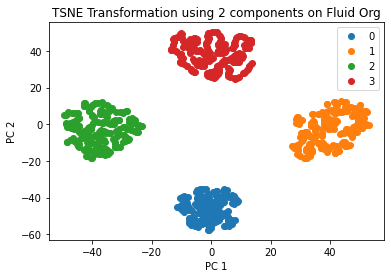

In [ ]:
for i in range(4):
    plt.plot(imgs_tsne.transpose()[0][labels==i],imgs_tsne.transpose()[1][labels==i],"o",label = f"{i}")
plt.legend()
plt.title("TSNE Transformation using 2 components on Fluid Org")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

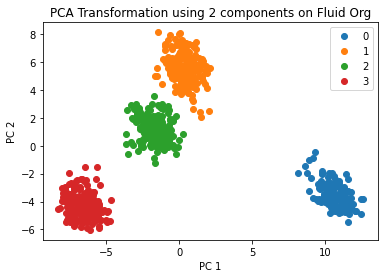

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(imgs_reshape)

for i in range(4):
    plt.plot(embedding_pca.transpose()[0][labels==i],embedding_pca.transpose()[1][labels==i],"o",label = f"{i}")
plt.legend()
plt.title("PCA Transformation using 2 components on Fluid Org")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

To build new model link for reference: https://keras.io/guides/sequential_model/

In [ ]:
# Now Train a classifier with the embeddings

inputs = keras.Input(shape=(imgs[0].shape))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(4)(x)  # because there are four outputs
classify_model = keras.Model(inputs, outputs)

In [ ]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test, labels_train, labels_test = train_test_split(imgs, labels, test_size = 0.2)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
classify_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),     
              loss=loss_fn,         
              metrics=['accuracy']) 

classify_model.fit(imgs_train, labels_train.astype(float), epochs = 10)

Epoch 1/10
19/19 [==============================] - 12s 372ms/step - loss: 3.0078 - accuracy: 0.4483
Epoch 2/10
19/19 [==============================] - 7s 369ms/step - loss: 1.1737 - accuracy: 0.4650
Epoch 3/10
19/19 [==============================] - 7s 369ms/step - loss: 1.1968 - accuracy: 0.4633
Epoch 4/10
19/19 [==============================] - 7s 372ms/step - loss: 1.2015 - accuracy: 0.4667
Epoch 5/10
19/19 [==============================] - 7s 370ms/step - loss: 1.2015 - accuracy: 0.4633
Epoch 6/10
19/19 [==============================] - 7s 370ms/step - loss: 1.1853 - accuracy: 0.4583
Epoch 7/10
19/19 [==============================] - 7s 370ms/step - loss: 1.1645 - accuracy: 0.4650
Epoch 8/10
19/19 [==============================] - 7s 372ms/step - loss: 1.1784 - accuracy: 0.4583
Epoch 9/10
19/19 [==============================] - 7s 371ms/step - loss: 1.2107 - accuracy: 0.4583
Epoch 10/10
19/19 [==============================] - 7s 371ms/step - loss: 1.1691 - accuracy: 0.460

In [ ]:
classify_model.evaluate(imgs_test, labels_test.astype(float))

5/5 [==============================] - 10s 1s/step - loss: 1.1660 - accuracy: 0.4636


[1.1659564971923828, 0.46357616782188416]

### (2) For advanced use of trainsfer learning from the pre-trained models such as fine-tuning, we need to do the transfer learning in-place, by building a network consists of the Inception and your classifier layers. 
Freeze the part you take from Inception, train
the model and report the accuracy. Then do the fine-tuning. Report
how much increase of accuracy you can manage to get. Fine tuning
by making the top few layer of the Inception model trainable instead
of freezing all the layers. Due to the slowness of training, unleash the
layers one by one. Make comments about how the accuracy change. It is
highly recommended that you train this on Google Colab with the GPU
activated.

Solution to (2): 

Used: https://www.tensorflow.org/guide/keras/transfer_learning for reference

In [ ]:
img_shape = imgs.shape[1:]
labels.shape

(751,)

In [ ]:
# Steps: Load Model
base_model = tf.keras.applications.InceptionV3(input_shape =(img_shape),include_top = False, weights = "imagenet", classes = 4)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 124, 249, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 124, 249, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
# make not trainable
base_model.trainable = False

In [ ]:
# create model on top
inputs = keras.Input(shape=(img_shape))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(4)(x)  # because there are four outputs
ft_model = keras.Model(inputs, outputs)

# global_avg_layer = keras.layers.GlobalAveragePooling2D()
# classifier_layer = tf.keras.layers.Dense(4)
# layers = [base_model,global_avg_layer,classifier_layer]
# ft_model = tf.keras.Sequential(layers)

ft_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 500, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 14, 2048)       21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
___________________________________________

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
ft_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),     
              loss=loss_fn,         
              metrics=['accuracy']) 

ft_model.fit(imgs_train, labels_train, epochs=10)

Epoch 1/10
19/19 [==============================] - 17s 372ms/step - loss: 2.1997 - accuracy: 0.3300
Epoch 2/10
19/19 [==============================] - 7s 368ms/step - loss: 1.3863 - accuracy: 0.3300
Epoch 3/10
19/19 [==============================] - 7s 368ms/step - loss: 1.3863 - accuracy: 0.3300
Epoch 4/10
19/19 [==============================] - 7s 369ms/step - loss: 1.3863 - accuracy: 0.3217
Epoch 5/10
19/19 [==============================] - 7s 369ms/step - loss: 1.3863 - accuracy: 0.3033
Epoch 6/10
19/19 [==============================] - 7s 371ms/step - loss: 1.3863 - accuracy: 0.3550
Epoch 7/10
19/19 [==============================] - 7s 369ms/step - loss: 1.3863 - accuracy: 0.3300
Epoch 8/10
19/19 [==============================] - 7s 371ms/step - loss: 1.3863 - accuracy: 0.3233
Epoch 9/10
19/19 [==============================] - 7s 369ms/step - loss: 1.3863 - accuracy: 0.3417
Epoch 10/10
19/19 [==============================] - 7s 369ms/step - loss: 1.3863 - accuracy: 0.340

In [ ]:
# Unfreeze the base model
base_model.trainable = True
len(base_model.layers)

#From layers 20 and down not trainable
for layer in base_model.layers[20:]:
    layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 124, 249, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 124, 249, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [ ]:
# check to see that the model runs smoothly
ft_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 500, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 14, 2048)       21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 192,820
Non-trainable params: 21,618,160
_________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(1e-5)
ft_model.compile(optimizer=opt,  # Very low learning rate
              loss=loss_fn,
              metrics=['accuracy'])

# Now fit on the new data again 
ft_model.fit(imgs_test, labels_test, epochs=10)

Epoch 1/10
5/5 [==============================] - 17s 1s/step - loss: 1.3863 - accuracy: 0.3576
Epoch 2/10
5/5 [==============================] - 5s 931ms/step - loss: 1.3863 - accuracy: 0.3311
Epoch 3/10
5/5 [==============================] - 5s 932ms/step - loss: 1.3863 - accuracy: 0.3046
Epoch 4/10
5/5 [==============================] - 5s 932ms/step - loss: 1.3863 - accuracy: 0.3576
Epoch 5/10
5/5 [==============================] - 5s 932ms/step - loss: 1.3863 - accuracy: 0.3576
Epoch 6/10
5/5 [==============================] - 5s 935ms/step - loss: 1.3863 - accuracy: 0.3311
Epoch 7/10
5/5 [==============================] - 5s 940ms/step - loss: 1.3863 - accuracy: 0.3311
Epoch 8/10
5/5 [==============================] - 5s 935ms/step - loss: 1.3863 - accuracy: 0.3377
Epoch 9/10
5/5 [==============================] - 5s 935ms/step - loss: 1.3863 - accuracy: 0.3576
Epoch 10/10
5/5 [==============================] - 5s 936ms/step - loss: 1.3863 - accuracy: 0.3974


From the fine-tuning, my model increased from around 0.34 to closer to 0.4. I assume that this is because that the higher layers were able to store/learn better from the train to improve the overall accuracy of the model. 
